# Precipitation in Boulder, CO 1948-2013

**Aims:** 
* to determine total monthly and annual precipitation in Boulder, CO during the years 1948 to 2013.
* to determine which calendar months have the most and least precipitation.
* to explore how annual precipitation has changed through recent decades.

First import the python packages that will be used in this notebook.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore, norm

import scipy.stats

%matplotlib inline

Read the csv file containing the data.

In [2]:
df = pd.read_csv('../data/precipitation/805333-precip-daily-1948-2013.csv')

Check the initial contents of the data.

In [3]:
 df.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement Flag,Quality Flag
0,COOP:050843,BOULDER 2 CO US,unknown,unknown,unknown,19480801 01:00,0.00,g,
1,COOP:050843,BOULDER 2 CO US,unknown,unknown,unknown,19480802 15:00,0.05,,
2,COOP:050843,BOULDER 2 CO US,unknown,unknown,unknown,19480803 09:00,0.01,,
3,COOP:050843,BOULDER 2 CO US,unknown,unknown,unknown,19480803 14:00,0.03,,
4,COOP:050843,BOULDER 2 CO US,unknown,unknown,unknown,19480803 15:00,0.03,,


Check what size the dataframe is. 

In [4]:
df.shape

(14476, 9)

Make the assumption that the column 'HPCP' refers to precipitation. The columns `DATE` and `HPCP` obviously will have different values, but what about the other columns?

Explore the contents of each of the columns:

In [5]:
ignore_columns = set(['DATE', 'HPCP'])

for column in list(set(df.columns)-ignore_columns):
    print('Column {} has unique value(s) {}'.format(column, df[column].unique()))

Column Measurement Flag has unique value(s) ['g' ' ' 'a' 'A' '[' ']' '{' '}']
Column ELEVATION has unique value(s) ['unknown' '1650.5']
Column STATION_NAME has unique value(s) ['BOULDER 2 CO US']
Column LATITUDE has unique value(s) ['unknown' '40.03333' '40.03417' '40.03389' '40.0338']
Column Quality Flag has unique value(s) [' ' 'q' 'R' 'Z']
Column LONGITUDE has unique value(s) ['unknown' '-105.26667' '-105.27694' '-105.28111' '-105.2811']
Column STATION has unique value(s) ['COOP:050843']


In this analysis, the columns above will be ignored.

In [6]:
df = df[['DATE', 'HPCP']]

Check to see if there are any null values in the dataframe.

In [7]:
df.isnull().sum()

DATE    0
HPCP    0
dtype: int64

Parse the `DATE` column of the dataframe.

In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

Set the index of the dataframe to the `DATE` column.

In [9]:
df.set_index('DATE', inplace=True)

The data contains erroneous values. A quick scan of `df.head(50)` shows several readings to be precisely 999.99, which is suspicious. As such, the question can be asked what are the unique readings above 3? 

In [10]:
filter_above_3 = df['HPCP'] > 3
df[filter_above_3]['HPCP'].unique()

array([999.99])

As can be seen, the only readings above 3.0 are 999.99. One can assume that these values are `NaN` values.

In order to replace the 999.99 values with `Nan`, a helper function called `replace_with_nan` will be created. This function takes a row of the dataframe, checks to see if its HPCP value is above 3, and replaces it with `np.nan` if so. 

In [11]:
def replace_with_nan(row):
    
    if row['HPCP'] > 3:
        row['HPCP'] = np.nan
    
    return row

Apply the function to each of the row. Note: `axis=1` needs to be set because the function needs to be applied to each of the rows in succession. 

In [12]:
df.apply(replace_with_nan, axis=1);

NaN values are now present in the dataframe:

In [13]:
df.isnull().sum()

HPCP    401
dtype: int64

These `Nan` values can be removed from the dataframe.

In [14]:
df = df.dropna()

A new dataframe called `df_monthly` is created that resamples the precipitation by month and sums it. 

In [15]:
df_monthly = df.resample('M').sum()

Use seaborn to plot the precipitation by month.

/home/david/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


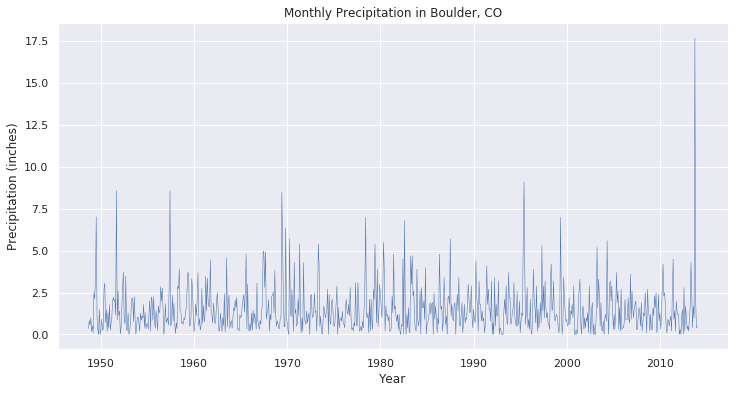

In [16]:
# decrease linewidth
sns.set(rc={"lines.linewidth": 0.5})

# increase plot size
plt.figure(figsize=(12, 6));

sns.lineplot(data=df_monthly, legend=False)
plt.xlabel('Year')
plt.ylabel('Precipitation (inches)')
plt.title('Monthly Precipitation in Boulder, CO');

As can be seen, the graph shows a lot of variability in the precipitation by month. One can see the sharp peak that occurred during the September 2013 flood.

In order to better understand the variability of the precipitation by month, a histogram can be constructed.

/home/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

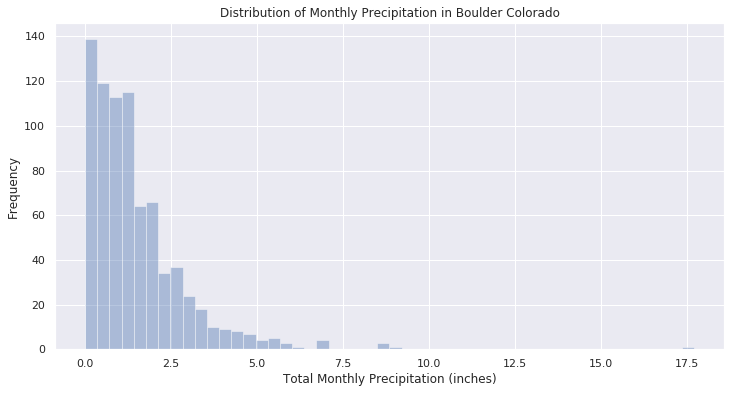

In [17]:
plt.figure(figsize=(12, 6));
sns.distplot(df_monthly['HPCP'],kde=False)
plt.title('Distribution of Monthly Precipitation in Boulder Colorado')
plt.xlabel('Total Monthly Precipitation (inches)')
plt.ylabel('Frequency')

How does the monthly precipitation vary between the months of the year? To answer this question, a column called `MONTH` that explicitly records the month can be created.

In [18]:
df_monthly['MONTH'] = df_monthly.index.month

A boxplot can be created for the precipitation for each of the calendar months. 

Text(0, 0.5, 'Total Monthly Precipitation (inches)')

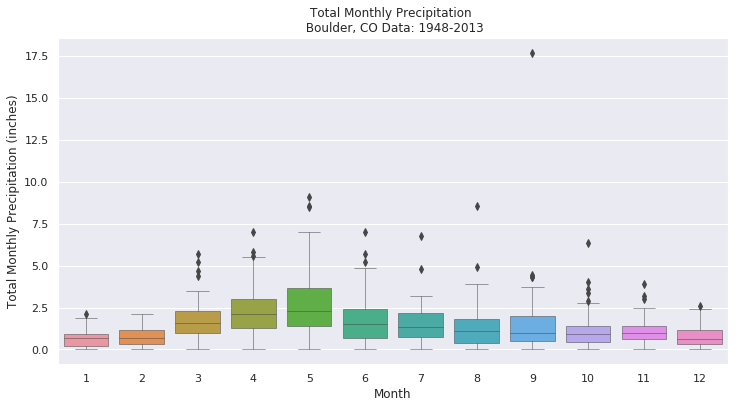

In [19]:
plt.figure(figsize=(12, 6));
sns.boxplot(data=df_monthly, x='MONTH', y='HPCP', showfliers=True)

plt.title('Total Monthly Precipitation \n Boulder, CO Data: 1948-2013')
plt.xlabel('Month')
plt.ylabel('Total Monthly Precipitation (inches)')


As can be seen from the plot above, the most rainfall occurs in May and the least in December. The flood of September 2013 is seen as an outlier. The same boxplot can be shown with outliers removed.

Text(0, 0.5, 'Total Monthly Precipitation (inches)')

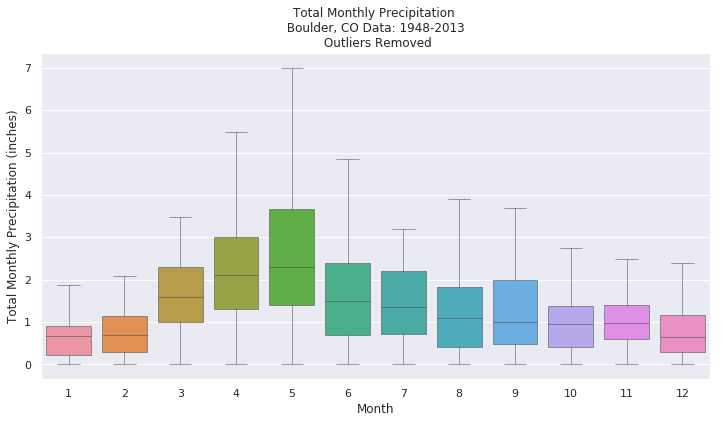

In [20]:
plt.figure(figsize=(12, 6));
sns.boxplot(data=df_monthly, x='MONTH', y='HPCP', showfliers=False)

plt.title('Total Monthly Precipitation \n Boulder, CO Data: 1948-2013 \n Outliers Removed')
plt.xlabel('Month')
plt.ylabel('Total Monthly Precipitation (inches)')


Total annual precipitation can also be considered. The dataframe `df_yearly` can be created that shows total annual precipitation.

In [21]:
df_yearly = df.resample('Y').sum()

A scatterplot can be created that shows the annual precipitation in Boulder, CO.

Text(0, 0.5, 'Precipitation (inches)')

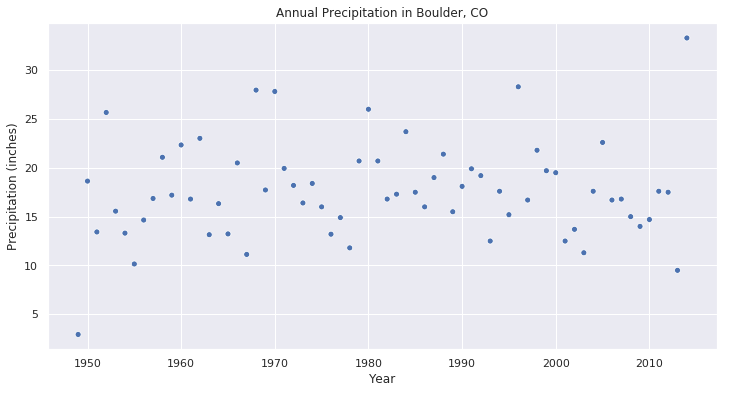

In [22]:
plt.figure(figsize=(12, 6));
sns.scatterplot(data=df_yearly, legend=False)

plt.title('Annual Precipitation in Boulder, CO');
plt.xlabel('Year')
plt.ylabel('Precipitation (inches)')


A histogram can be constructed for the annual precipitation in Boulder.

Text(0, 0.5, 'Frequency')

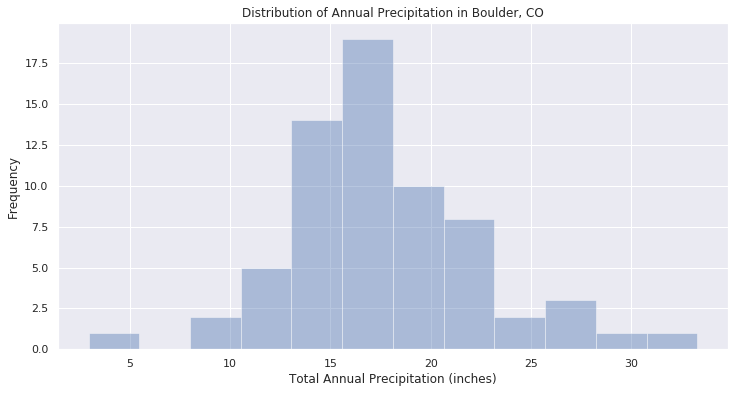

In [23]:
plt.figure(figsize=(12, 6));
sns.distplot(df_yearly['HPCP'], kde=False)

plt.title('Distribution of Annual Precipitation in Boulder, CO');
plt.xlabel('Total Annual Precipitation (inches)')
plt.ylabel('Frequency')


Total precipitation in each decade can be determined. This will allow comparisons between the decades to be made. A new dataframe `df_decade` can be constructed that shows the total precipitation for each of the decades.

In [24]:
df_decade = df_yearly.groupby((df_yearly.index.year//10)*10).median()
df_decade.reset_index(inplace=True)

In [25]:
df_decade

,DATE,HPCP
0,1940,10.785
1,1950,16.210
2,1960,17.265
3,1970,17.300
4,1980,17.800
5,1990,19.350
6,2000,14.850
7,2010,17.550


The first and last decades do not have complete data, as such, we need to drop the decades 1940-1950 and 2010-2020.

In [26]:
df_decade = df_decade.drop([0,7])

A bar plot can be made that shows the total rainfall for each of the decades.

Text(0, 0.5, 'Total Precipitation In Decade')

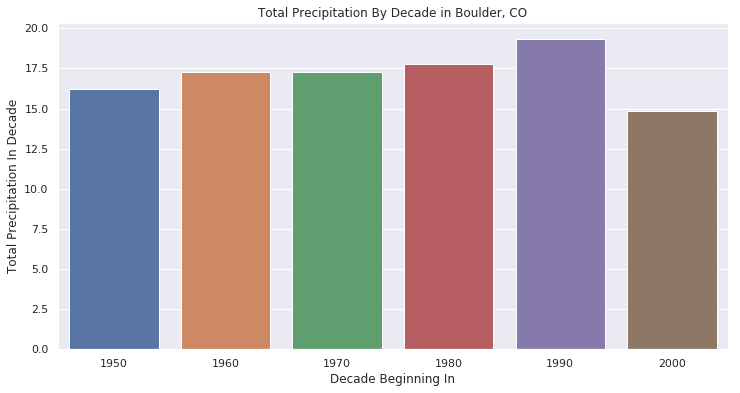

In [27]:
plt.figure(figsize=(12, 6));
sns.barplot(data=df_decade, x='DATE', y='HPCP')

plt.title('Total Precipitation By Decade in Boulder, CO');
plt.xlabel('Decade Beginning In')
plt.ylabel('Total Precipitation In Decade')

The annual precipitation can also be grouped into decades so that a box plot can be produced. In order to do this, a column `DECADE` can be constructed in the `df_yearly` dataframe that explicitly records the decade each year falls in.

In [28]:
df_yearly['DECADE']=(df_yearly.index.year//10)*10

In [29]:
df_yearly

,HPCP,DECADE
DATE,,
1948-12-31,2.93,1940
1949-12-31,18.64,1940
1950-12-31,13.43,1950
1951-12-31,25.67,1950
1952-12-31,15.56,1950
1953-12-31,13.31,1950
1954-12-31,10.15,1950
1955-12-31,14.65,1950
1956-12-31,16.86,1950


A box plot can now be produced which groups the years of each decade separately. 

Text(0, 0.5, 'Total Precipitation In Decade')

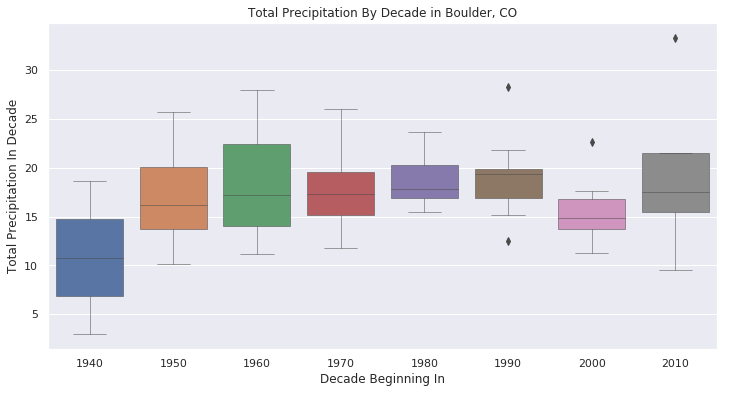

In [30]:
plt.figure(figsize=(12, 6));
sns.boxplot(data=df_yearly, x='DECADE', y='HPCP', showfliers=True)

plt.title('Total Precipitation By Decade in Boulder, CO');
plt.xlabel('Decade Beginning In')
plt.ylabel('Total Precipitation In Decade')


From the plot above, it can be seen that later decades have less variability in the total precipitation falling. For example, 1992's total annual precipitation is an outlier for that decade, but would not be classified as an outlier in comparison to the decade 1950-1959.